In [1]:
import os

import pandas as pd
import numpy as np
from typing import Dict, List
from os.path import join
from eyefeatures.preprocessing.fixation_extraction import IVT
from timeit import default_timer

from eyefeatures.visualization.static_visualization import scanpath_visualization

DATA_PATH = join(
    "..", "data", "experiments", "Eye-Tracking-Data"
)

x = 'Gaze X'
y = 'Gaze Y'
t = 'EventIDE TimeStamp'
xx, yy = 'Center X (pix)', 'Center Y (pix)'

## Code for experiment

### Gazes processing and fixation extraction

In [2]:
from collections import defaultdict

def normalize(df, x, y):
    df[x] = (df[x] - df[x].min()) / (df[x].max() - df[x].min())
    df[y] = (df[y] - df[y].min()) / (df[y].max() - df[y].min())
    return df

def get_gazes(part_path: str) -> pd.DataFrame:
    part_id = int(os.path.basename(part_path))
    gazes = pd.read_csv(join(part_path, "TrackerLog.csv"), sep=',', skiprows=3)
    gazes["PartID"] = part_id
    gazes["TextID"] = -1
    gazes["LoopID"] = -1
    text_id = defaultdict(lambda: 1)
    loop_id = -1
    l, r    = 0, 0  # [l, r)
    is_end  = True
    while r < len(gazes):
        event = gazes.loc[r, "Current Event"]
        if "Text" in event:
            loop_id = int(event.split(' ')[1][-1])
            if is_end:
                is_end = False
                l = r
        else:
            if not is_end:
                is_end = True
                if l != r:
                    gazes.loc[l:r, "TextID"] = text_id[loop_id]
                    gazes.loc[l:r, "LoopID"] = loop_id
                    text_id[loop_id] += 1
        r += 1

    if not is_end:
        gazes.loc[l:r, "TextID"] = text_id
        gazes.loc[l:r, "LoopID"] = loop_id

    return gazes

def get_fixations(part_path: str, folder: str) -> pd.DataFrame:
    part_id = int(os.path.basename(part_path))
    loop_id = int(folder[-1])
    path = join(part_path, folder)
    scanpath_files = sorted(os.listdir(path))
    scanpath_dfs = []
    for scanpath_file in scanpath_files:
        text_id = int(scanpath_file.split('_')[1].split('.')[0])
        fixations = pd.read_csv(join(path, scanpath_file), index_col="Fixation Number")
        fixations["TextID"] = text_id
        fixations["PartID"] = part_id
        fixations["LoopID"] = loop_id
        scanpath_dfs.append(fixations)
    return pd.concat(scanpath_dfs)

def get_comparison(threshold, min_duration, input_gazes, verbose=True):
    def _print(x):
        if verbose:
            print(x)

    results = {}

    part_paths = [
        join(DATA_PATH, part)
        for part in os.listdir(DATA_PATH)
    ]

    for part_path in part_paths:
        if "." in os.path.basename(part_path):
            continue

        _print(part_path)

        part_id = int(os.path.basename(part_path))
        part_gazes = input_gazes[input_gazes["PartID"] == part_id]
        for folder in os.listdir(part_path):
            if "loop" not in folder:
                continue
            _print(folder)

            loop_id = int(folder[-1])
            fixations = get_fixations(part_path, folder)
            fixations = normalize(fixations, xx, yy)
            loop_gazes = part_gazes[part_gazes.LoopID == loop_id]

            for text_id in loop_gazes.TextID.value_counts().index:
                gazes = loop_gazes[loop_gazes.TextID == text_id][[x, y, t]].reset_index(drop=True)

                _print(f"PartID: {part_id}, LoopID: {loop_id}, TextID: {text_id}, n_gazes: {len(gazes)}")

                our_params = {'threshold': threshold, 'min_duration': min_duration}
                fixations_extractor = IVT(x=x, y=y, t=t, pk=None,
                                          threshold=our_params['threshold'],
                                          min_duration=our_params['min_duration'])

                start_ts = default_timer()
                our_fixations = fixations_extractor.fit_transform(gazes)
                end_ts = default_timer()

                their_fixations = fixations[(fixations.TextID == text_id) & (fixations.LoopID == loop_id) & (fixations.PartID == part_id)]

                results_our = {
                    "time": end_ts - start_ts,
                    "fixation_count": len(our_fixations),
                    "avg_duration"  : our_fixations['duration'].mean()
                }
                results_their = {
                    "fixation_count": len(their_fixations),
                    "avg_duration"  : their_fixations['Duration'].mean()
                }
                results[join(part_path, folder, f"text_{text_id}")] = {
                    "part_id": part_id,
                    "loop_id": loop_id,
                    "text_id": text_id,
                    "our": results_our,
                    "their": results_their,
                    "our_fixations": our_fixations,
                    "their_fixations": their_fixations,
                    "gazes": gazes
                }
    return results

### Helper functions

In [3]:
def print_results(results):
    results_dfs = {}
    for k, v in results.items():
        our = pd.DataFrame.from_dict(v['our'], orient='index')
        our.columns = ['our']
        their = pd.DataFrame.from_dict(v['their'], orient='index')
        their.columns = ['their']
        df = pd.concat([our, their], axis=1)
    
        results_dfs[k] = df
        print(df)
        print("\n")

def plot_diff(results, k):    
    our_fixations = results[k]["our_fixations"]
    their_fixations = results[k]["their_fixations"]
    
    print("OUR")
    scanpath_visualization(
        our_fixations,
        x,
        y,
        path_width=1,
        show_plot=True,
    )
    print("THEIRS")
    scanpath_visualization(
        their_fixations,
        'Center X (pix)',
        'Center Y (pix)',
        path_width=1,
        show_plot=True
    )

In [4]:
from eyefeatures.features.scanpath_dist import calc_dtw_dist, calc_hau_dist, calc_euc_dist


def print_metrics(metrics):
    print(f"Cnt diff: {metrics["cnt"]:.2f}")
    print(f"Euc diff: {metrics["euc"]:.5f}")
    print(f"Hau diff: {metrics["hau"]:.5f}")
    print(f"Dtw diff: {metrics["dtw"]:.5f}")

def calc_metrics(results, verbose=True):
    total_cnt_diff = []
    total_euc_diff = []
    total_hau_diff = []
    total_dtw_diff = []
    all_metrics = {}
    for k, v in results.items():
        o, t = v["our_fixations"][[x, y]], v["their_fixations"][[xx, yy]]
        n = min([len(o), len(t)])
        if n <= 1:
            continue
        cnt, euc, hau, dtw = abs(len(o) - len(t)), calc_euc_dist(o, t) / n, calc_hau_dist(o, t) / n, calc_dtw_dist(o, t) / n
        total_cnt_diff.append(cnt)
        total_euc_diff.append(euc)
        total_hau_diff.append(hau)
        total_dtw_diff.append(dtw)
        
        all_metrics[k] = {
            "cnt": cnt,
            "euc": euc,
            "hau": hau,
            "dtw": dtw
        }

    avg_metrics = {
        "cnt": sum(total_cnt_diff) / len(total_cnt_diff),
        "euc": sum(total_euc_diff) / len(total_euc_diff),
        "hau": sum(total_hau_diff) / len(total_hau_diff),
        "dtw": sum(total_dtw_diff) / len(total_dtw_diff)
    }
    if verbose:
        print_metrics(avg_metrics)
    return avg_metrics, all_metrics

## Results

### Metrics

In [5]:
input_gazes = pd.read_csv(join(DATA_PATH, "Eye-Tracking-Data-All-Gazes.csv"))
results = get_comparison(threshold=0.0005, min_duration=70, input_gazes=input_gazes, verbose=False)
avg_metrics, all_metrics = calc_metrics(results, verbose=False)
print_metrics(avg_metrics)

Cnt diff: 9.54
Euc diff: 0.11503
Hau diff: 0.00192
Dtw diff: 0.06194


### Plots

In [6]:
metric_name = "dtw"
min_k, max_k = -1, -1
min_dist, max_dist = np.inf, -np.inf
for k in all_metrics:
    if all_metrics[k][metric_name] > max_dist:
        max_dist = all_metrics[k][metric_name]
        max_k = k
    if all_metrics[k][metric_name] < min_dist:
        min_dist = all_metrics[k][metric_name]
        min_k = k

Scanpath with smallest metric value:

In [7]:
print(f"{min_dist:.4f}")

0.0282


OUR
THEIRS


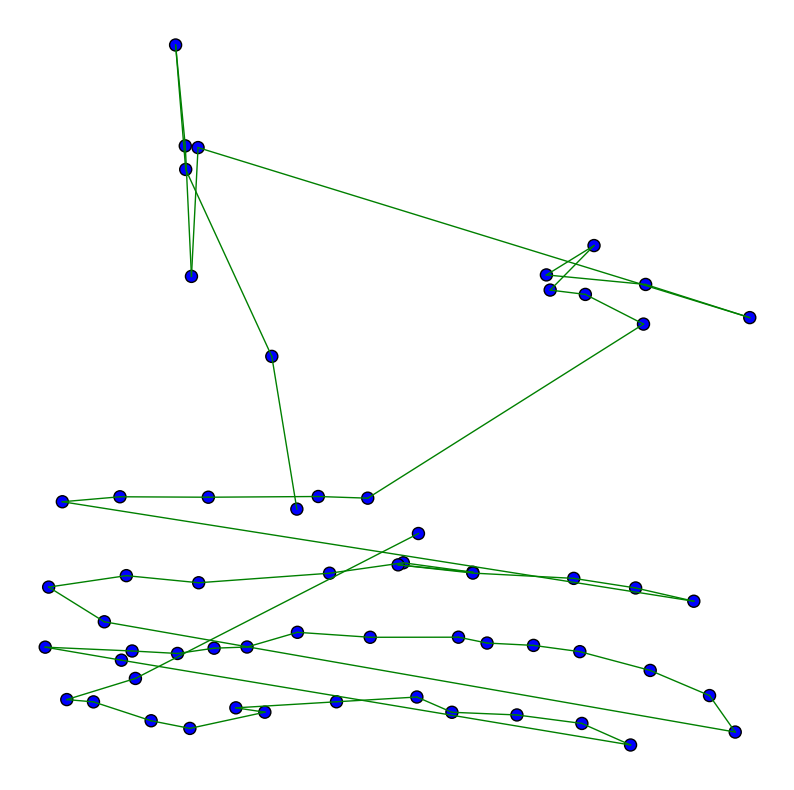

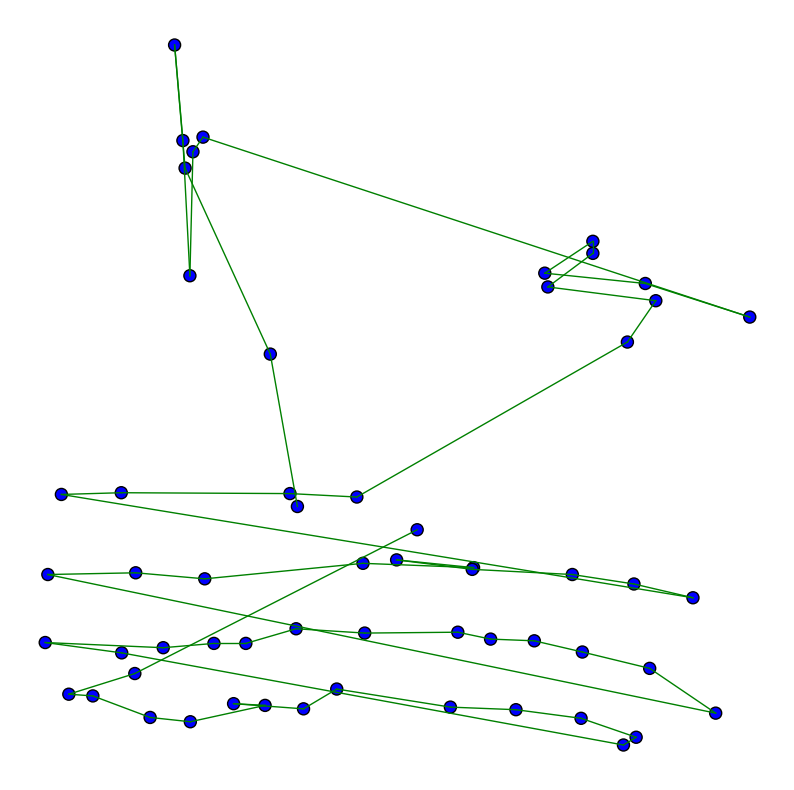

In [8]:
plot_diff(results, min_k)

Scanpath with largest metric value:

In [9]:
print(f"{max_dist:.4f}")

0.2062


OUR
THEIRS


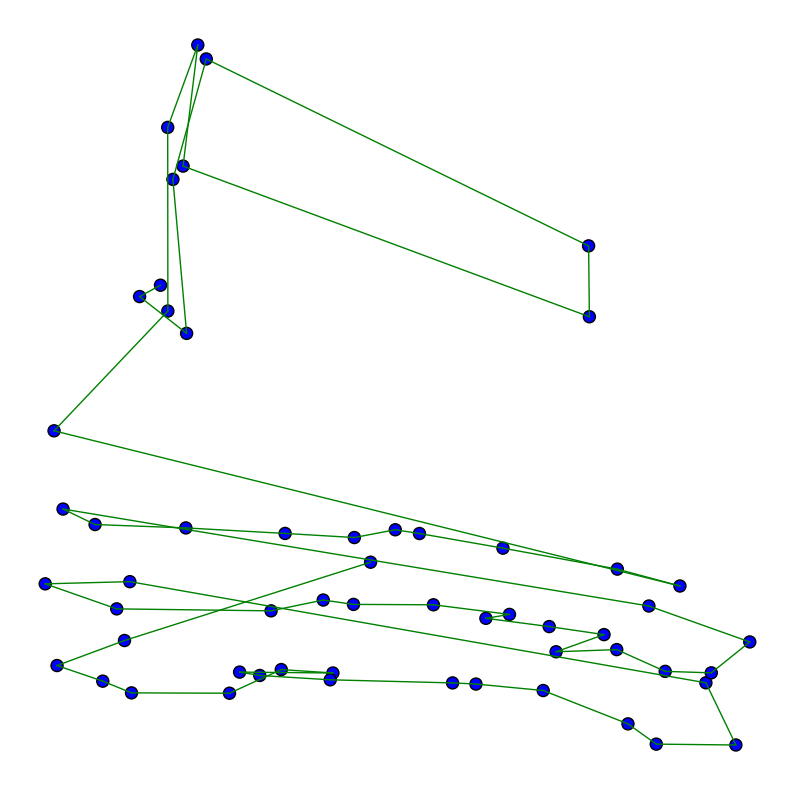

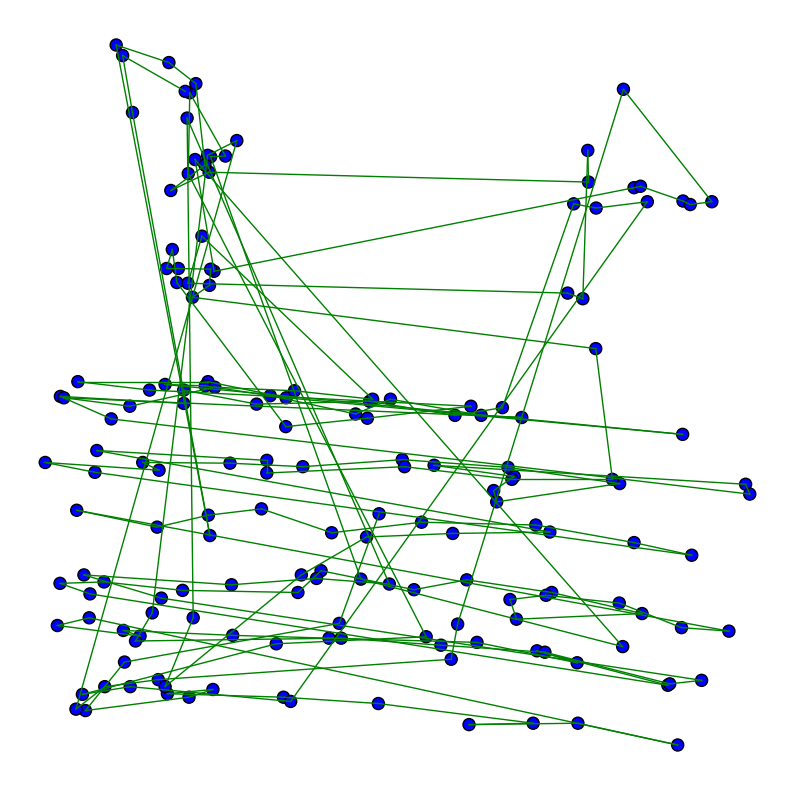

In [10]:
plot_diff(results, max_k)